In [1]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSSv2 import *
# np.random.seed(13)
%load_ext autoreload
%autoreload 2

The following is the correlation matrix of sources


<IPython.core.display.Math object>

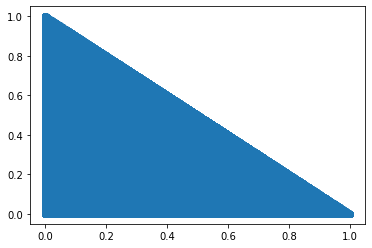

In [2]:
N = 500000
NumberofSources = 5
NumberofMixtures = 10
S = generate_correlated_copula_sources(rho = 0.0, df = 4, n_sources = NumberofSources, size_sources = N , decreasing_correlation = True)
S = 4 * S - 2
S = ProjectRowstoL1NormBall(S.T).T
S = S* (S>=0)

print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

plt.scatter(S[0,:], S[2,:])

In [3]:
# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

print("The following is the mixture matrix A")
display_matrix(A)

SNR = 30 # dB
NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)
NoisePart = NoiseAmp * np.random.randn(X.shape[0], X.shape[1])
X = X  + NoisePart
SNRinp = 10 * np.log10(np.sum(np.var(X, axis = 1)) / np.sum(np.var(NoisePart, axis = 1)))
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 24.24589909409141


In [4]:
lambday = 1 - 1e-1/10
lambdae = 1 - 1e-7/10
beta = 30
s_dim = S.shape[0]
x_dim = X.shape[0]

# Inverse output covariance
By = 5 * np.eye(s_dim)
# Inverse error covariance
Be = 1 * np.eye(s_dim)

debug_iteration_point = 1000
model = OnlineLDMIBSS(s_dim = s_dim, x_dim = x_dim, muW = 1e-3, lambday = lambday,
                      lambdae = lambdae, beta = beta, By = By, Be = Be, neural_OUTPUT_COMP_TOL = 1e-6,
                      set_ground_truth = True, S = S, A = A)

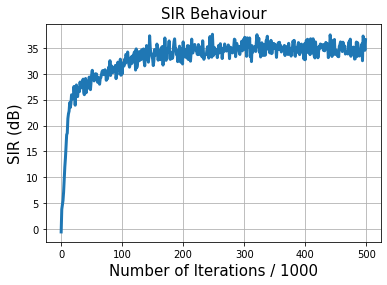

100%|█████████████████████████████████| 500000/500000 [02:26<00:00, 3419.62it/s]


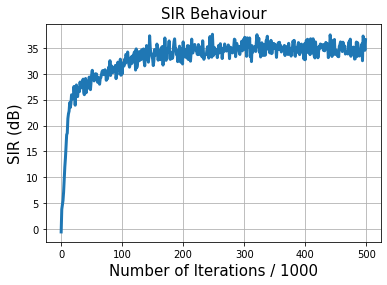

In [5]:
model.fit_batch_nnsparse(X = X, n_epochs = 1, neural_dynamic_iterations = 500,
                             plot_in_jupyter = True, neural_lr_start = 0.1,
                             neural_lr_stop = 0.001, debug_iteration_point = debug_iteration_point, 
                             shuffle = True)